# Importing Modules and Data Preprocessing

In [2]:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input


import os
import tqdm
from datetime import datetime

!pip install pandas_ta
#!pip install doltpy
#!pip install --user doltcli




In [3]:
import pandas_ta as ta
#import doltcli as dolt

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp -r /content/drive/MyDrive/Stock_Predictor_Project_Files* /content/









Mounted at /content/drive


In [5]:

# Define stock ticker
ticker = "AAPL"
stock = yf.Ticker(ticker)

# 1️⃣ Download historical stock data with actions (dividends & splits)
aapl_df = yf.download(ticker, start="2000-01-01", end=None, actions=True)
#aapl_df = aapl_df.ta.ticker(ticker)


# 3️⃣ Get company info
info = stock.info
company_info = {
    "Name": info.get("longName"),
    "Sector": info.get("sector"),
    "Industry": info.get("industry"),
    "Market Cap": info.get("marketCap"),
    "52-Week High": info.get("fiftyTwoWeekHigh"),
    "52-Week Low": info.get("fiftyTwoWeekLow"),
    "Dividend Yield": info.get("dividendYield"),
}



# 4️⃣ Get financial statements (balance sheet, income statement, cash flow)
income_statement = pd.read_csv(f"/content/Stock_Predictor_Project_Files/{ticker.lower()}_income_statement.csv")
balance_sheet_assets = pd.read_csv(f"/content/Stock_Predictor_Project_Files/{ticker.lower()}_balance_sheet_assets.csv")
balance_sheet_equity = pd.read_csv(f"/content/Stock_Predictor_Project_Files/{ticker.lower()}_balance_sheet_equity.csv")
balance_sheet_liabilities = pd.read_csv(f"/content/Stock_Predictor_Project_Files/{ticker.lower()}_balance_sheet_liabilities.csv")
cash_flow_statement = pd.read_csv(f"/content/Stock_Predictor_Project_Files/{ticker.lower()}_cash_flow_statement.csv")



financials = {
    "Income Statement": income_statement,
    "Balance Sheet Assets": balance_sheet_assets,
    "Balance Sheet Equity": balance_sheet_equity,
    "Balance Sheet Liabilities": balance_sheet_liabilities,
    "Cash Flow": cash_flow_statement
}


# 5️⃣ Save everything to an Excel file
with pd.ExcelWriter(rf"C:\Users\maxco\Documents\Personal Projects\Stock Predictor Project\{ticker}_stock_data.xlsx") as writer:
    aapl_df.to_excel(writer, sheet_name="Stock Prices")  # Historical stock data
    pd.DataFrame([company_info]).to_excel(writer, sheet_name="Company Info")  # Company details
    for key, df in financials.items():
        df.to_excel(writer, sheet_name=key)  # Financial statements






YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
# Flatten the multiindex columns to single-level column names
# by joining the levels with an underscore.
aapl_df.columns = ['_'.join(col) for col in aapl_df.columns]

# Remove the ticker symbol ('AAPL') from the column names
# (if you want to keep just the column names).
aapl_df.columns = [col.replace('_AAPL', '') for col in aapl_df.columns]
aapl_df = aapl_df.rename(columns={'Date_': 'Date'})

In [7]:
'''
financials['Income Statement'] = financials["Income Statement"].set_index('date')
financials['Balance Sheet Assets'] = financials["Balance Sheet Assets"].set_index('date')
financials['Balance Sheet Equity'] = financials["Balance Sheet Equity"].set_index('date')
financials['Balance Sheet Liabilities'] = financials["Balance Sheet Liabilities"].set_index('date')
financials['Cash Flow'] = financials["Cash Flow"].set_index('date')
'''


'\nfinancials[\'Income Statement\'] = financials["Income Statement"].set_index(\'date\')\nfinancials[\'Balance Sheet Assets\'] = financials["Balance Sheet Assets"].set_index(\'date\')\nfinancials[\'Balance Sheet Equity\'] = financials["Balance Sheet Equity"].set_index(\'date\')\nfinancials[\'Balance Sheet Liabilities\'] = financials["Balance Sheet Liabilities"].set_index(\'date\')\nfinancials[\'Cash Flow\'] = financials["Cash Flow"].set_index(\'date\')\n'


# Adding Features

In [8]:
# Calculating Metrics
'''
aapl_df['EPS'] = (financials["Income Statement"]["net_income","date"])/(financials["Balance Sheet Equity"]["shares_outstanding",["date"]])

divided_series = financials["Income Statement"]["net_income"]/financials["Balance Sheet Equity"]["shares_outstanding"]
divided_series = divided_series.reindex(aapl_df.index)
divided_series.info()





#financials["Income Statement"]["net_income"]
#print(len(financials["Income Statement"]["net_income"].index))
#print(len(financials["Balance Sheet Equity"]["shares_outstanding"].index))
'''




'\naapl_df[\'EPS\'] = (financials["Income Statement"]["net_income","date"])/(financials["Balance Sheet Equity"]["shares_outstanding",["date"]])\n\ndivided_series = financials["Income Statement"]["net_income"]/financials["Balance Sheet Equity"]["shares_outstanding"]\ndivided_series = divided_series.reindex(aapl_df.index)\ndivided_series.info()\n\n\n\n\n\n#financials["Income Statement"]["net_income"]\n#print(len(financials["Income Statement"]["net_income"].index))\n#print(len(financials["Balance Sheet Equity"]["shares_outstanding"].index))\n'

In [9]:
aapl_df["10_day_MA"] = aapl_df["Close"].rolling(window=10, min_periods=1).mean()
aapl_df["5_day_MA"] = aapl_df["Close"].rolling(window=5, min_periods=1).mean()
aapl_df["3_day_MA"] = aapl_df["Close"].rolling(window=3, min_periods=1).mean()

'''
Example with Steps Counter
📊 SMA (Simple Moving Average) - Abrupt Changes

Day 20: Average is based on steps from days 1-20.
Day 21: We drop day 1's steps completely and add day 21’s.
If day 1 had really low steps, the new average suddenly jumps up when we drop it.
📈 RMA (Rolling Moving Average) - Smoother Change


Instead of dropping day 1 completely, we gradually reduce its influence while adding more weight to new days.
The change in average is much smoother day to day.
'''



aapl_df["1_day_pct_change"] = aapl_df["Close"].pct_change()*100
aapl_df["3_day_pct_change"] = aapl_df["Close"].pct_change(periods=3)*100
aapl_df["5_day_pct_change"] = aapl_df["Close"].pct_change(periods=5)*100
aapl_df["10_day_pct_change"] = aapl_df["Close"].pct_change(periods=10)*100

# Market Cap
#aapl_df["Market Cap"] = aapl_df["Close"] * financials["Balance Sheet Equity"]["shares_outstanding"]

# Earnings Per Share (EPS)
aapl_df['EPS'] = stock.info['trailingEps']  # Using trailingEps from stock.info

# Price-to-Earnings Ratio (P/E)
aapl_df['PE_Ratio'] = stock.info['trailingPE']  # Using trailingPE from stock.info

# Dividend Yield
aapl_df['Dividend_Yield'] = stock.info['dividendYield'] # Using dividendYield from stock.info

# Relative Strength Index
aapl_df['RSI'] = ta.rsi(close=aapl_df['Close'], window=14)


# Calculate MACD
macd_df = ta.macd(close=aapl_df['Close'])

# Add MACD values to aapl_df
aapl_df['MACD'] = macd_df['MACD_12_26_9']  # Assuming default parameters
aapl_df['MACD_Signal'] = macd_df['MACDs_12_26_9']
aapl_df['MACD_Hist'] = macd_df['MACDh_12_26_9']

# Bollinger Bands calculation
bbands_df = ta.bbands(close=aapl_df['Close']) # might be better to use EMA instead of SMA

# Add Bollinger Band columns to aapl_df
aapl_df['BBL'] = bbands_df['BBL_5_2.0']  # Lower Band
aapl_df['BBM'] = bbands_df['BBM_5_2.0']  # Middle Band
aapl_df['BBU'] = bbands_df['BBU_5_2.0']  # Upper Band

'''
🔥 How It Affects Bollinger Bands
EMA-based Bollinger Bands react faster to price changes 📈📉
SMA-based Bollinger Bands are smoother and respond slower
💡 EMA is better for short-term trends, while SMA is better for long-term analysis
'''

# Average True Range
aapl_df['ATR'] = ta.atr(high=aapl_df['High'], low=aapl_df['Low'], close=aapl_df['Close'])

#Schochastic Oscillator
stoch_df = ta.stoch(high=aapl_df['High'], low=aapl_df['Low'], close=aapl_df['Close'])

# Get the stochastic oscillator values from the DataFrame returned by ta.stoch
aapl_df['SlowK'] = stoch_df['STOCHk_14_3_3']
aapl_df['SlowD'] = stoch_df['STOCHd_14_3_3']

#On-Balance Volume
aapl_df['OBV'] = ta.obv(close=aapl_df['Close'], volume=aapl_df['Volume'])

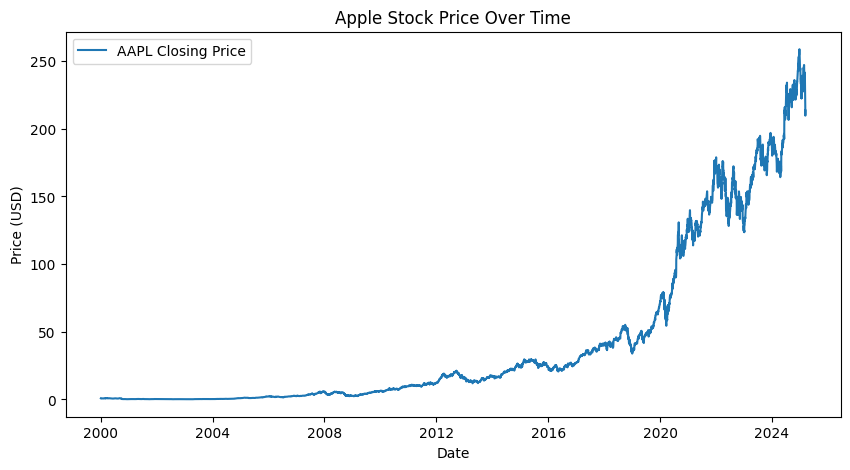

In [10]:

# Plot closing prices over time
plt.figure(figsize=(10, 5))
plt.plot(aapl_df.index, aapl_df["Close"], label="AAPL Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Apple Stock Price Over Time")
plt.legend()
plt.show()


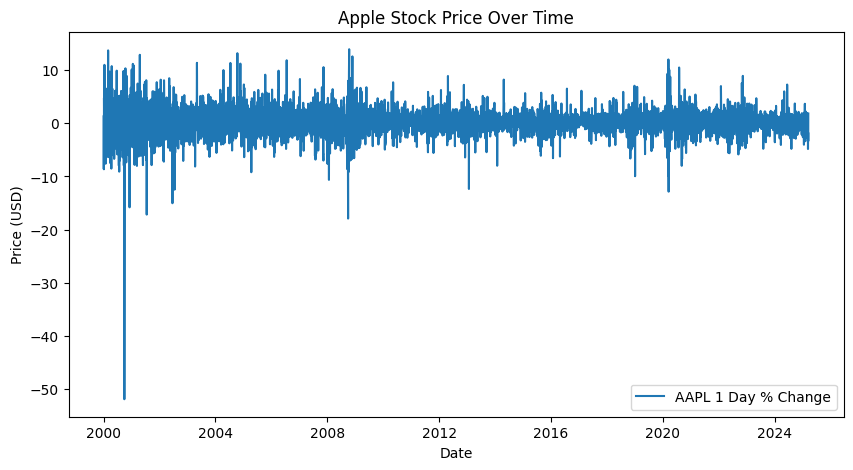

In [11]:

# 1 day pct change over time
plt.figure(figsize=(10, 5))
plt.plot(aapl_df.index, aapl_df["1_day_pct_change"], label="AAPL 1 Day % Change")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Apple Stock Price Over Time")
plt.legend()
plt.show()


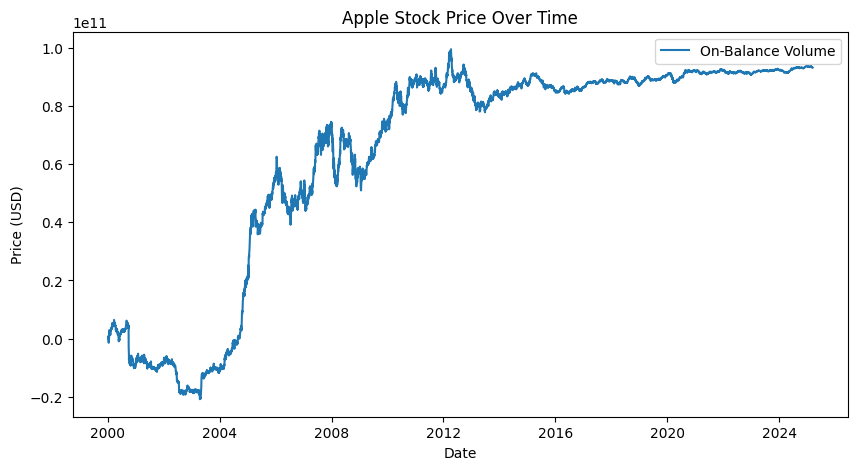

In [12]:

# OBV over time
plt.figure(figsize=(10, 5))
plt.plot(aapl_df.index, aapl_df["OBV"], label="On-Balance Volume")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Apple Stock Price Over Time")
plt.legend()
plt.show()


In [13]:
#LSTM: Dynamic model that trains on various time intervals

# Grouping/Plotting

In [14]:
aapl_df.dropna(inplace=True)  # Removes rows with NaN values

In [15]:
aapl_df

,Close,Dividends,High,Low,Open,Stock Splits,Volume,10_day_MA,5_day_MA,3_day_MA,...,MACD,MACD_Signal,MACD_Hist,BBL,BBM,BBU,ATR,SlowK,SlowD,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-18,0.836979,0.0,0.868012,0.834157,0.862370,0.0,233441600,0.856821,0.865285,0.853279,...,0.026588,0.026945,-0.000357,0.827516,0.865285,0.903054,0.046102,73.124498,82.288731,3.304661e+09
2000-02-22,0.856257,0.0,0.879768,0.802653,0.828514,0.0,422296000,0.856633,0.862276,0.852495,...,0.025650,0.026686,-0.001035,0.824507,0.862276,0.900045,0.048511,71.840237,76.495170,3.726957e+09
2000-02-23,0.874595,0.0,0.895285,0.835097,0.851908,0.0,473099200,0.857668,0.858138,0.855944,...,0.026087,0.026566,-0.000479,0.833485,0.858138,0.882790,0.049413,72.230652,72.398462,4.200056e+09
2000-02-24,0.866719,0.0,0.896225,0.840740,0.882589,0.0,376432000,0.859607,0.859760,0.865857,...,0.025503,0.026353,-0.000851,0.834149,0.859760,0.885372,0.049879,75.181033,73.083974,3.823624e+09
2000-02-25,0.830395,0.0,0.880238,0.828514,0.863781,0.0,249144000,0.857256,0.852989,0.857236,...,0.021857,0.025454,-0.003597,0.819132,0.852989,0.886845,0.050020,61.314058,69.575248,3.574480e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,227.479996,0.0,236.160004,224.220001,235.539993,0.0,72071200,237.812000,234.710001,233.960002,...,-0.678959,0.615813,-1.294772,227.004609,234.710001,242.415392,6.655201,29.796939,31.903501,9.324051e+10
2025-03-11,220.839996,0.0,225.839996,217.449997,223.809998,0.0,76137400,235.192000,231.692001,229.130000,...,-1.922398,0.108171,-2.030569,218.438674,231.692001,244.945329,6.896258,23.478751,29.768419,9.316437e+10
2025-03-12,216.979996,0.0,221.750000,214.910004,220.139999,0.0,62547500,232.853999,227.939999,221.766663,...,-3.182616,-0.549987,-2.632629,211.225155,227.939999,244.654844,6.892239,9.653093,20.976261,9.310182e+10


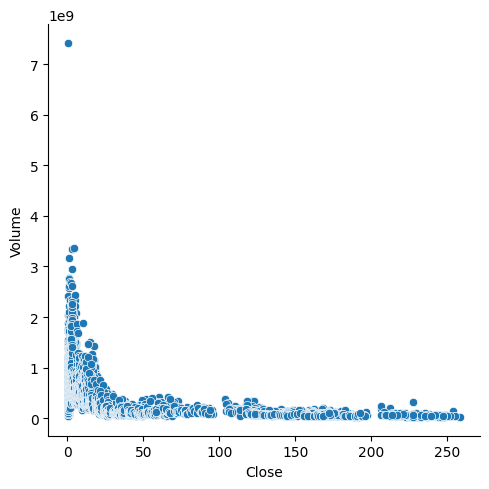

In [16]:
sns.relplot(x="Close", y="Volume", kind="scatter", data=aapl_df)

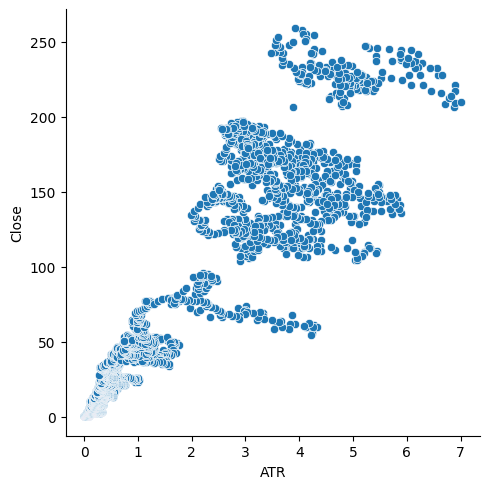

In [17]:
sns.relplot(x="ATR", y="Close", kind="scatter", data=aapl_df)

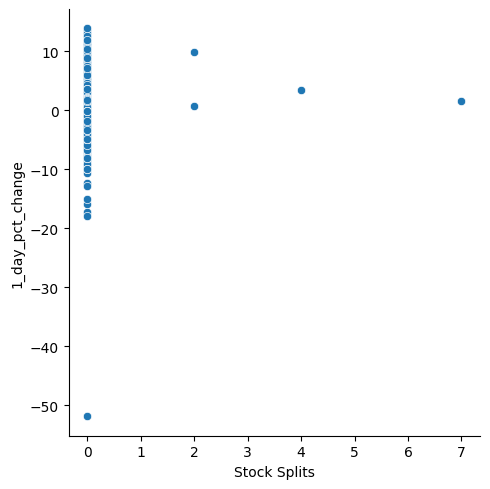

In [18]:
sns.relplot(x="Stock Splits", y="1_day_pct_change", kind="scatter", data=aapl_df)

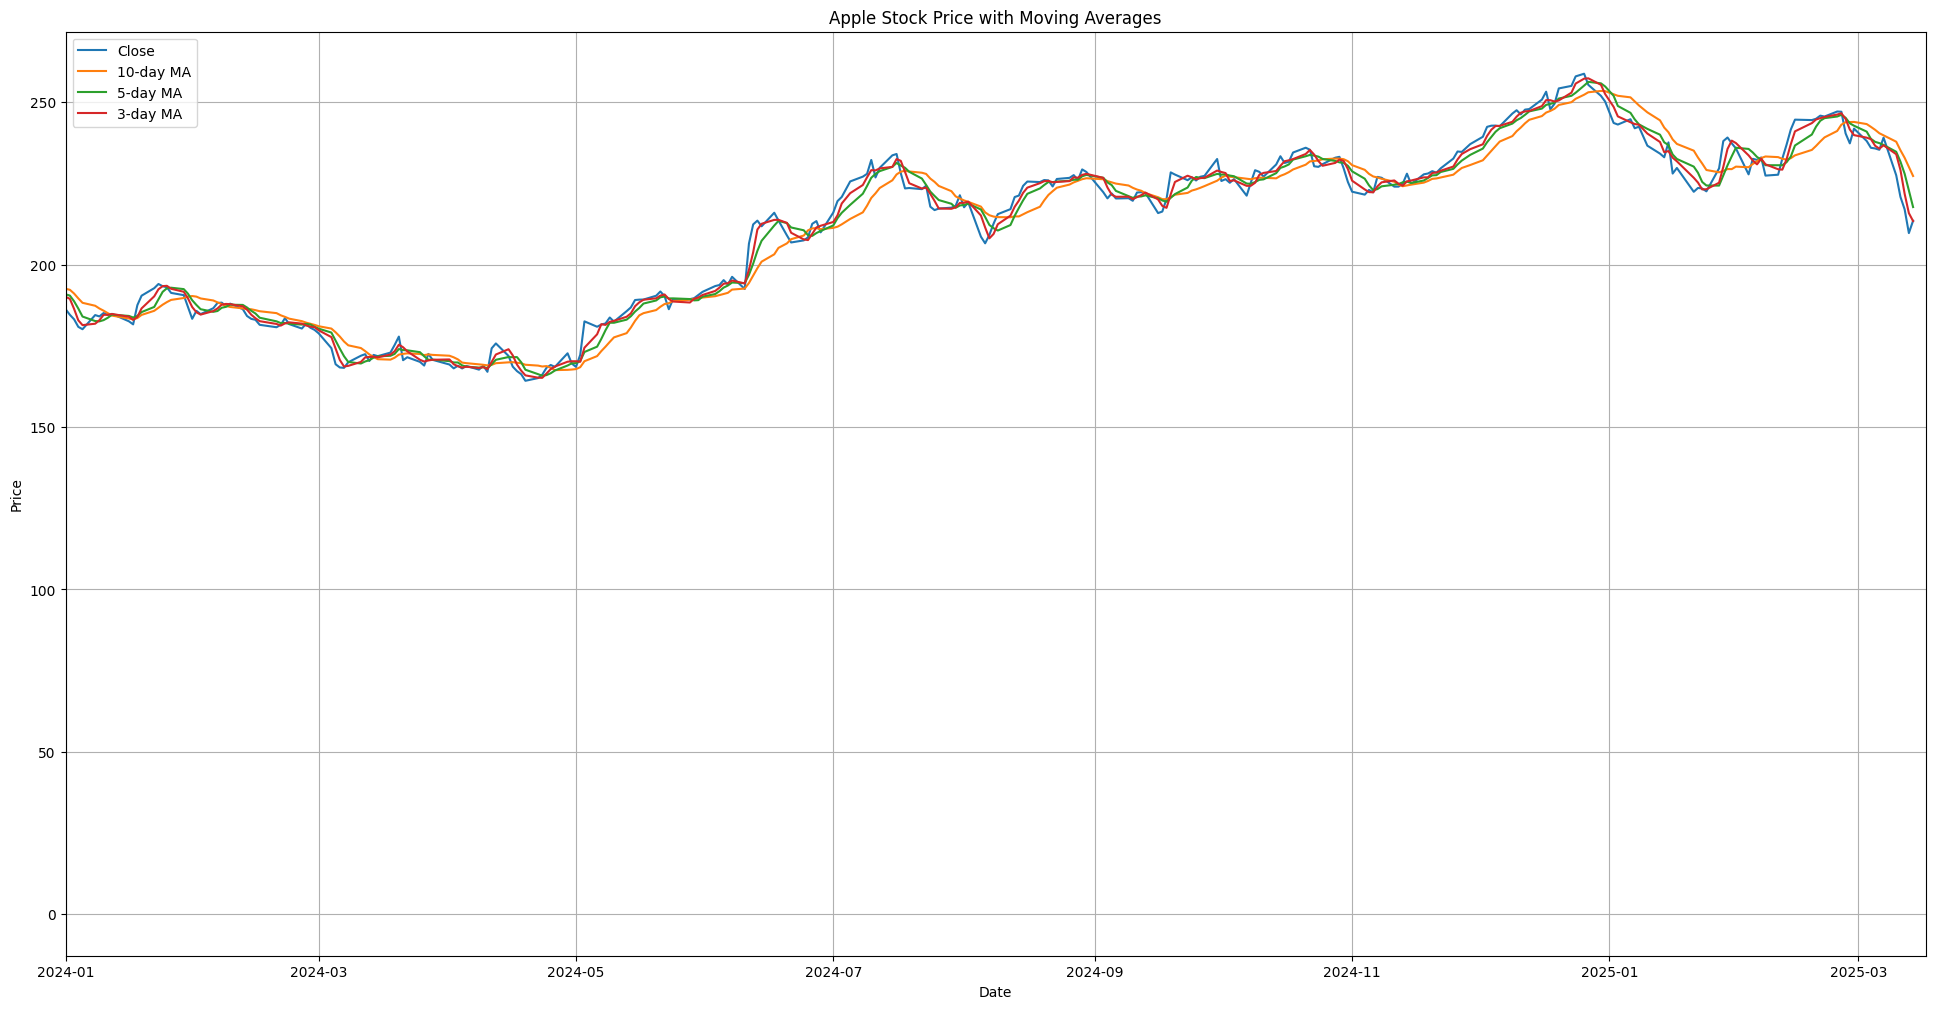

In [19]:

plt.figure(figsize=(24, 12))  # Adjust figure size as needed
plt.plot(aapl_df.index, aapl_df["Close"], label="Close")
plt.plot(aapl_df.index, aapl_df["10_day_MA"], label="10-day MA")
plt.plot(aapl_df.index, aapl_df["5_day_MA"], label="5-day MA")
plt.plot(aapl_df.index, aapl_df["3_day_MA"], label="3-day MA")
plt.xlabel("Date")
plt.xlim(datetime(2024,1,1),datetime.now())
plt.ylabel("Price")
plt.title("Apple Stock Price with Moving Averages")
plt.legend()
plt.grid(True)
plt.show()

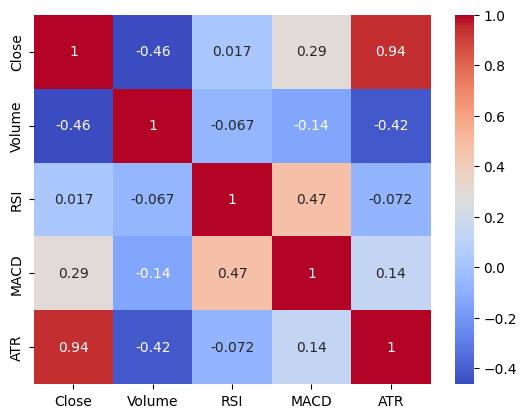

In [20]:
correlation_matrix = aapl_df[['Close', 'Volume', 'RSI', 'MACD', 'ATR']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
#NOTES:
# High correlation between Close and ATR
# Moderate negative correlation between close and volume
# Moderate correlation between MACD and RSI
# Moderate negative correlation between volume and ATR

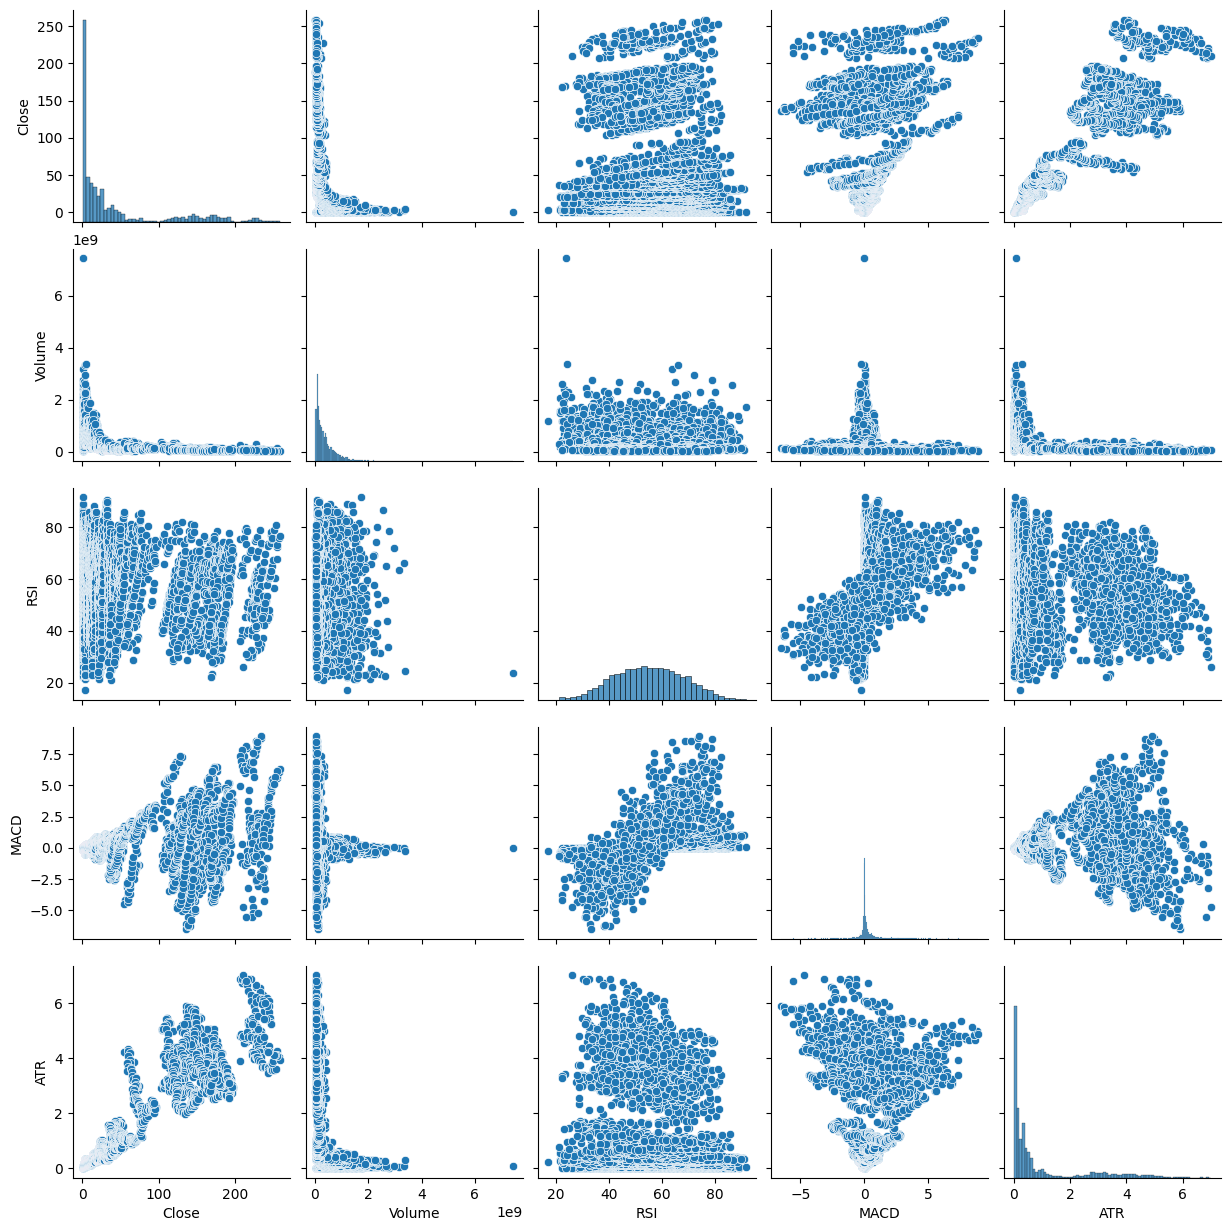

In [21]:
sns.pairplot(aapl_df[['Close', 'Volume', 'RSI', 'MACD', 'ATR']])
plt.show()

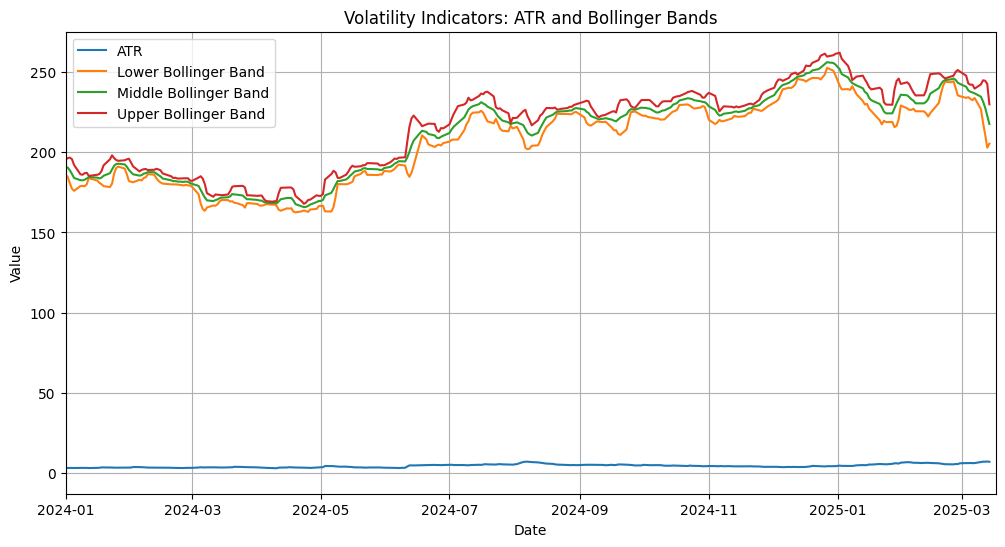

In [22]:
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(aapl_df.index, aapl_df["ATR"], label="ATR")
plt.plot(aapl_df.index, aapl_df["BBL"], label="Lower Bollinger Band")
plt.plot(aapl_df.index, aapl_df["BBM"], label="Middle Bollinger Band")
plt.plot(aapl_df.index, aapl_df["BBU"], label="Upper Bollinger Band")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xlim(datetime(2024,1,1),datetime.now())
plt.title("Volatility Indicators: ATR and Bollinger Bands")
plt.legend()
plt.grid(True)
plt.show()

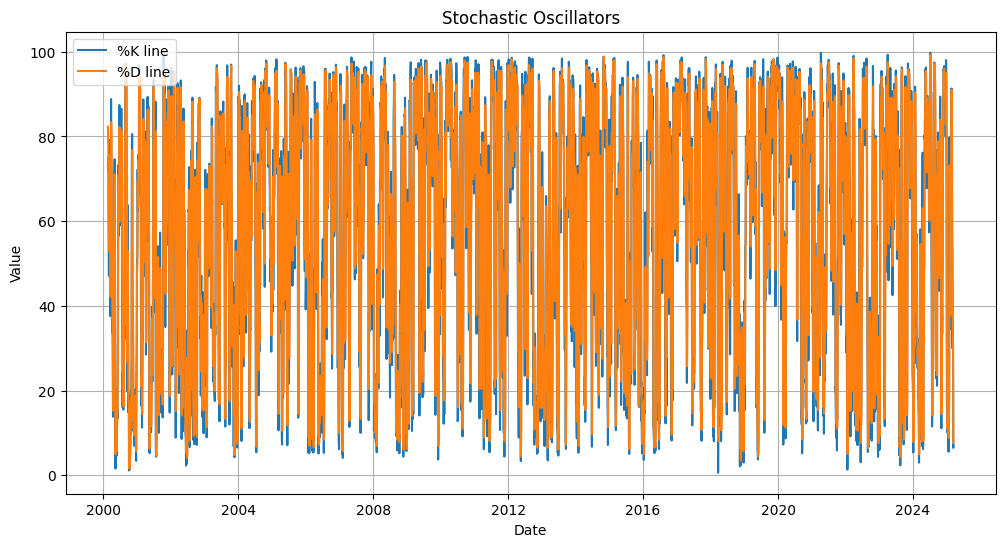

In [23]:
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(aapl_df.index, aapl_df["SlowK"], label="%K line")
plt.plot(aapl_df.index, aapl_df["SlowD"], label="%D line")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Stochastic Oscillators")
plt.legend()
plt.grid(True)
plt.show()

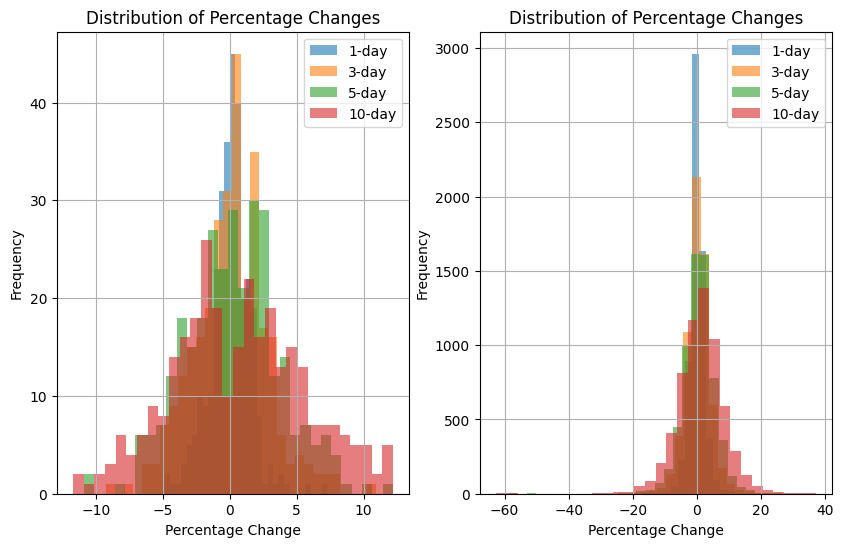

In [24]:
fig, plts = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))  # Adjust figure size as needed
plts[0].hist(aapl_df["1_day_pct_change"].loc[datetime(2024,1,1):datetime.now()], bins=30, alpha=0.6, label="1-day")
plts[0].hist(aapl_df["3_day_pct_change"].loc[datetime(2024,1,1):datetime.now()], bins=30, alpha=0.6, label="3-day")
plts[0].hist(aapl_df["5_day_pct_change"].loc[datetime(2024,1,1):datetime.now()], bins=30, alpha=0.6, label="5-day")
plts[0].hist(aapl_df["10_day_pct_change"].loc[datetime(2024,1,1):datetime.now()], bins=30, alpha=0.6, label="10-day")
plts[0].set_xlabel("Percentage Change")
plts[0].set_ylabel("Frequency")
plts[0].set_title("Distribution of Percentage Changes")
plts[0].legend()
plts[0].grid(True)


plts[1].hist(aapl_df["1_day_pct_change"], bins=30, alpha=0.6, label="1-day")
plts[1].hist(aapl_df["3_day_pct_change"], bins=30, alpha=0.6, label="3-day")
plts[1].hist(aapl_df["5_day_pct_change"], bins=30, alpha=0.6, label="5-day")
plts[1].hist(aapl_df["10_day_pct_change"], bins=30, alpha=0.6, label="10-day")
plts[1].set_xlabel("Percentage Change")
plts[1].set_ylabel("Frequency")
plts[1].set_title("Distribution of Percentage Changes")
plts[1].legend()
plts[1].grid(True)

In [25]:
aapl_df['10_day_pct_change'].loc[abs(aapl_df['10_day_pct_change']) >= 30]
#Most volatile during lower prices and 2008 recession

,10_day_pct_change
Date,
2000-09-29,-53.380523
2000-10-02,-60.020563
2000-10-03,-62.773677
2000-10-04,-61.300256
2000-10-05,-61.080511
2000-10-06,-57.485077
2000-10-09,-59.345767
2000-10-10,-59.416754
2000-10-11,-59.897896


In [26]:
aapl_df['ATR'].loc[((aapl_df['ATR'] >= (aapl_df['ATR'].mean())+(3*(aapl_df['ATR'].std()))) | (aapl_df['ATR'] <= aapl_df['ATR'].mean())-(3*(aapl_df['ATR'].std())))]

,ATR
Date,
2000-02-18,0.046102
2000-02-22,0.048511
2000-02-23,0.049413
2000-02-24,0.049879
2000-02-25,0.050020
...,...
2025-03-10,6.655201
2025-03-11,6.896258
2025-03-12,6.892239


<ipython-input-27-5ce6a156405c>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["1-day", "3-day", "5-day", "10-day"])


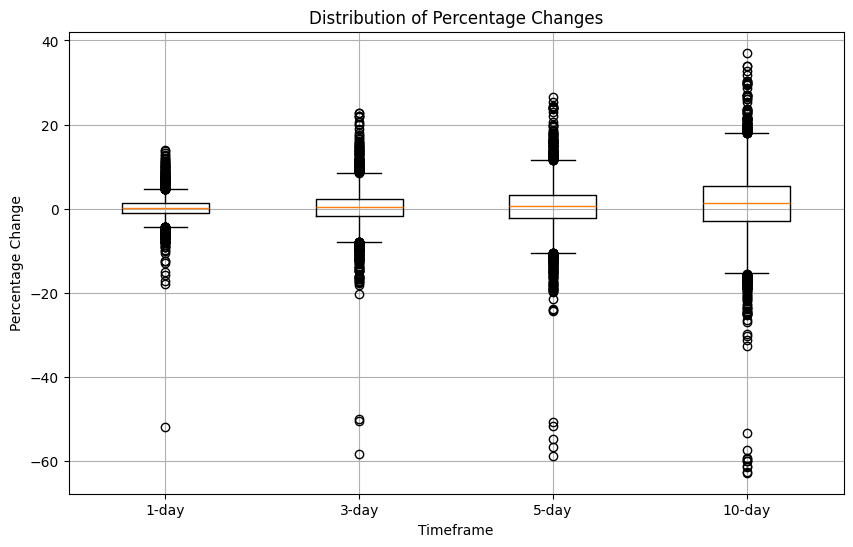

In [27]:


data = [aapl_df["1_day_pct_change"],
        aapl_df["3_day_pct_change"],
        aapl_df["5_day_pct_change"],
        aapl_df["10_day_pct_change"]]

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.boxplot(data, labels=["1-day", "3-day", "5-day", "10-day"])
plt.xlabel("Timeframe")
plt.ylabel("Percentage Change")
plt.title("Distribution of Percentage Changes")
plt.grid(True)
plt.show()

<Axes: xlabel='1_day_pct_change', ylabel='Density'>

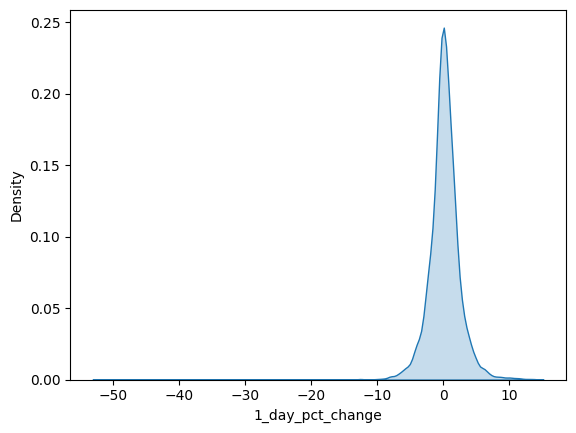

In [28]:
sns.kdeplot(aapl_df["1_day_pct_change"], label="1-day", fill=True)
#sns.kdeplot(aapl_df["3_day_pct_change"], label="3-day")
#sns.kdeplot(aapl_df["5_day_pct_change"], label="5-day")

<Axes: >

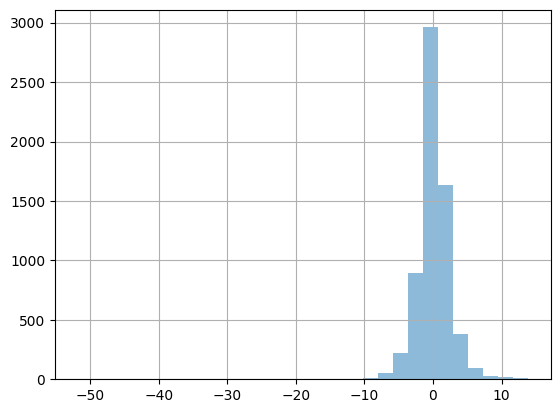

In [29]:
aapl_df["1_day_pct_change"].hist(bins=30, alpha=0.5, label="1-day")

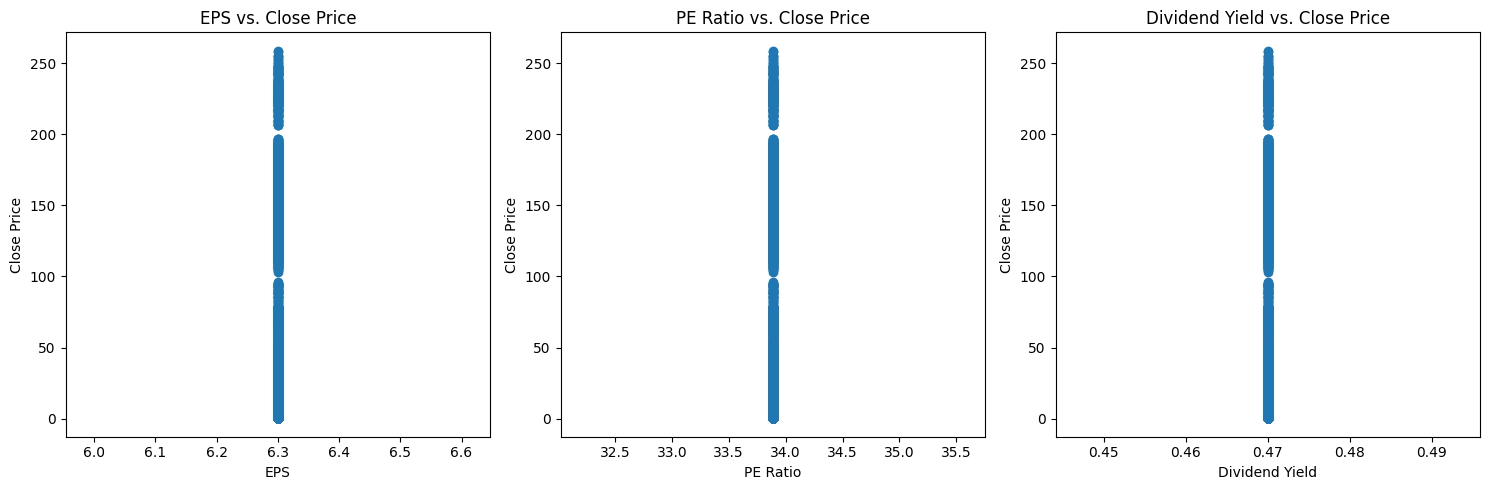

In [30]:


# Create scatter plots for each fundamental indicator vs. Close
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
plt.scatter(aapl_df['EPS'], aapl_df['Close'])
plt.xlabel('EPS')
plt.ylabel('Close Price')
plt.title('EPS vs. Close Price')

plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
plt.scatter(aapl_df['PE_Ratio'], aapl_df['Close'])
plt.xlabel('PE Ratio')
plt.ylabel('Close Price')
plt.title('PE Ratio vs. Close Price')

plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
plt.scatter(aapl_df['Dividend_Yield'], aapl_df['Close'])
plt.xlabel('Dividend Yield')
plt.ylabel('Close Price')
plt.title('Dividend Yield vs. Close Price')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Target Feature Analysis

In [31]:
aapl_df["Price Movement"] = np.where(aapl_df["1_day_pct_change"] > 0, 1, 0) # TARGET FEATURE

<Axes: ylabel='Density'>

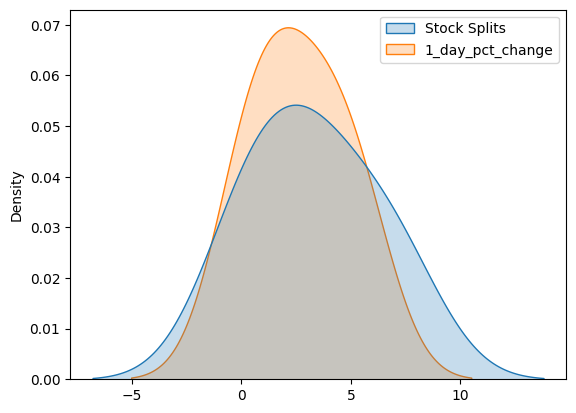

In [32]:
sns.kdeplot(aapl_df.groupby(['Stock Splits'], as_index=False)['1_day_pct_change'].mean(), label='Stock Splits x Average 1 Day Growth', fill=True)
#aapl_df.groupby(['Stock Splits'], as_index=False)['1_day_pct_change']*100['Stock Splits' == aapl_df['Stock Splits']].mean()
# Shows when there is a stock split price of the stock will go up
# WEIRD THAT IT IS NEGATIVE


In [33]:
aapl_df.groupby(['Stock Splits'], as_index=False)['1_day_pct_change'].mean()


,Stock Splits,1_day_pct_change
0,0.0,0.115491
1,2.0,5.348477
2,4.0,3.391229
3,7.0,1.600175


In [34]:
import pandas as pd

# Assuming aapl_df is your DataFrame

# 1. Get the dates where stock splits occurred

stock_split_dates = [d.date() for d in aapl_df[aapl_df['Stock Splits'] > 0].index]

# 2. Function to calculate percentage change for a given number of days
def get_pct_change_after_split(days_after_split):
    pct_change_column = f'{days_after_split}_day_pct_change'  # Construct column name

    # Use a list comprehension to get percentage changes for each split date
    pct_changes = [
        aapl_df.loc[pd.Timestamp(split_date + pd.DateOffset(days=days_after_split)).floor('D'), pct_change_column]
        for split_date in stock_split_dates
        if pd.Timestamp(split_date + pd.DateOffset(days=days_after_split)).floor('D') in aapl_df.index
    ]

    return pct_changes

# ... (rest of your code) ...

# 3. Get the percentage changes for 1, 3, 5, and 10 days after splits
#pct_change_1_day = get_pct_change_after_split(1)
#pct_change_3_day = get_pct_change_after_split(3)
pct_change_5_day = get_pct_change_after_split(5)
#pct_change_10_day = get_pct_change_after_split(10)

# 4. Print or use the results as needed
#print(f"1-day percentage changes after stock splits: {pct_change_1_day}")
#print(f"3-day percentage changes after stock splits: {pct_change_3_day}")
print(f"5-day percentage changes after stock splits: {pct_change_5_day}")
#print(f"10-day percentage changes after stock splits: {pct_change_10_day}")

5-day percentage changes after stock splits: [12.031072049668046]


In [35]:
aapl_df.index

DatetimeIndex(['2000-02-18', '2000-02-22', '2000-02-23', '2000-02-24',
               '2000-02-25', '2000-02-28', '2000-02-29', '2000-03-01',
               '2000-03-02', '2000-03-03',
               ...
               '2025-03-03', '2025-03-04', '2025-03-05', '2025-03-06',
               '2025-03-07', '2025-03-10', '2025-03-11', '2025-03-12',
               '2025-03-13', '2025-03-14'],
              dtype='datetime64[ns]', name='Date', length=6305, freq=None)

In [36]:
aapl_df['1 day change GB'] = pd.qcut(aapl_df['1_day_pct_change'],8)

In [37]:
aapl_df.groupby(['1 day change GB'], as_index = False)['1_day_pct_change'].mean()

<ipython-input-37-1e8a4720189f>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aapl_df.groupby(['1 day change GB'], as_index = False)['1_day_pct_change'].mean()


,1 day change GB,1_day_pct_change
0,"(-51.87, -2.115]",-3.751196
1,"(-2.115, -0.978]",-1.477314
2,"(-0.978, -0.382]",-0.656134
3,"(-0.382, 0.0905]",-0.142634
4,"(0.0905, 0.613]",0.341853
5,"(0.613, 1.26]",0.908742
6,"(1.26, 2.262]",1.692092
7,"(2.262, 13.905]",4.032747


<Axes: xlabel='1_day_pct_change', ylabel='Density'>

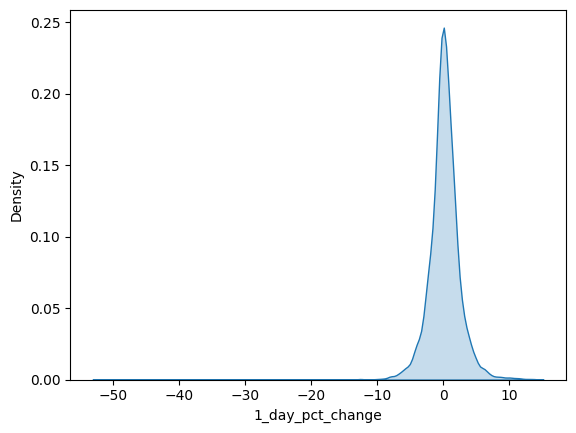

In [38]:
aapl_df['3 day MA GB'] = pd.qcut(aapl_df['3_day_MA'],8)
sns.kdeplot(aapl_df["1_day_pct_change"], label="1-day", fill=True)

In [39]:
aapl_df.groupby(['3 day MA GB'], as_index = False)['1_day_pct_change'].mean()
# Plot a histogram for visualization

<ipython-input-39-5f7b767ba204>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aapl_df.groupby(['3 day MA GB'], as_index = False)['1_day_pct_change'].mean()


,3 day MA GB,1_day_pct_change
0,"(0.197, 0.363]",0.081126
1,"(0.363, 2.077]",0.162626
2,"(2.077, 5.541]",0.173962
3,"(5.541, 14.432]",0.134819
4,"(14.432, 25.081]",0.080432
5,"(25.081, 45.336]",0.081310
6,"(45.336, 144.06]",0.193689
7,"(144.06, 257.32]",0.035328


In [40]:
aapl_df['RSI GB'] = pd.qcut(aapl_df['RSI'],8)

In [41]:
aapl_df.groupby(['RSI GB'], as_index = False)['1_day_pct_change'].mean()

<ipython-input-41-394db9e4f122>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aapl_df.groupby(['RSI GB'], as_index = False)['1_day_pct_change'].mean()


,RSI GB,1_day_pct_change
0,"(17.070999999999998, 39.538]",-1.477602
1,"(39.538, 45.187]",-0.470473
2,"(45.187, 50.212]",-0.060343
3,"(50.212, 54.726]",0.262220
4,"(54.726, 59.462]",0.303244
5,"(59.462, 64.297]",0.567862
6,"(64.297, 70.394]",0.755652
7,"(70.394, 91.503]",1.064711


In [42]:
aapl_df['MACD GB'] = pd.qcut(aapl_df['MACD'],8)

In [43]:
aapl_df.groupby(['MACD GB'], as_index = False)['1_day_pct_change'].mean()
# PLOT to observe correlation

<ipython-input-43-41c45bafe6f2>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aapl_df.groupby(['MACD GB'], as_index = False)['1_day_pct_change'].mean()


,MACD GB,1_day_pct_change
0,"(-6.5120000000000005, -0.323]",-0.075140
1,"(-0.323, -0.0285]",-0.127686
2,"(-0.0285, 0.00287]",0.055191
3,"(0.00287, 0.0329]",0.227415
4,"(0.0329, 0.114]",0.259299
5,"(0.114, 0.32]",0.225458
6,"(0.32, 1.092]",0.140379
7,"(1.092, 8.925]",0.238575


In [44]:
aapl_df['MACD_Signal GB'] = pd.qcut(aapl_df['MACD_Signal'],8)

In [45]:
aapl_df.groupby(['MACD_Signal GB'], as_index = False)['1_day_pct_change'].mean() # PLOT

<ipython-input-45-87e563c6ef63>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aapl_df.groupby(['MACD_Signal GB'], as_index = False)['1_day_pct_change'].mean() # PLOT


,MACD_Signal GB,1_day_pct_change
0,"(-5.674, -0.288]",0.059526
1,"(-0.288, -0.0279]",0.002545
2,"(-0.0279, 0.00361]",0.166901
3,"(0.00361, 0.034]",0.121816
4,"(0.034, 0.114]",0.217180
5,"(0.114, 0.307]",0.175986
6,"(0.307, 0.994]",0.040621
7,"(0.994, 8.292]",0.158747


In [46]:
aapl_df['MACD_Hist GB'] = pd.qcut(aapl_df['MACD_Hist'],8)

In [47]:
aapl_df.groupby(['MACD_Hist GB'], as_index = False)['1_day_pct_change'].mean() # NEGATIVE MACD HIST IMPLIES NEGATIVE ONE DAY PCT CHANGE??
#GROUP

<ipython-input-47-61d5343dc55e>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aapl_df.groupby(['MACD_Hist GB'], as_index = False)['1_day_pct_change'].mean() # NEGATIVE MACD HIST IMPLIES NEGATIVE ONE DAY PCT CHANGE??


,MACD_Hist GB,1_day_pct_change
0,"(-3.342, -0.155]",-0.309777
1,"(-0.155, -0.038]",-0.325140
2,"(-0.038, -0.00587]",-0.082687
3,"(-0.00587, 0.000476]",-0.034815
4,"(0.000476, 0.00896]",0.469968
5,"(0.00896, 0.0437]",0.409660
6,"(0.0437, 0.178]",0.377665
7,"(0.178, 2.337]",0.438915


In [48]:
aapl_df['BBL GB'] = pd.qcut(aapl_df['BBL'],8)

In [49]:
aapl_df.groupby(['BBL GB'], as_index = False)['1_day_pct_change'].mean() # Analyzing the distance between the upper and lower band may be more useful
# Increase in BBL GB is just an increase in stock price basically shows range

<ipython-input-49-c3f1e76c6bbb>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aapl_df.groupby(['BBL GB'], as_index = False)['1_day_pct_change'].mean() # Analyzing the distance between the upper and lower band may be more useful


,BBL GB,1_day_pct_change
0,"(0.0919, 0.346]",0.072047
1,"(0.346, 1.992]",0.184603
2,"(1.992, 5.329]",0.166566
3,"(5.329, 13.862]",0.126778
4,"(13.862, 24.56]",0.094585
5,"(24.56, 44.28]",0.083798
6,"(44.28, 139.843]",0.177811
7,"(139.843, 252.701]",0.037117


In [50]:
aapl_df['ATR GB'] = pd.qcut(aapl_df['ATR'],8)

In [51]:
aapl_df.groupby(['ATR GB'], as_index = False)['1_day_pct_change'].mean()
# Plot to observe potential association between ATR and pct change in a day

<ipython-input-51-5f6dc485b174>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aapl_df.groupby(['ATR GB'], as_index = False)['1_day_pct_change'].mean()


,ATR GB,1_day_pct_change
0,"(0.0049, 0.0173]",0.186654
1,"(0.0173, 0.0631]",0.200079
2,"(0.0631, 0.169]",0.146574
3,"(0.169, 0.304]",0.063455
4,"(0.304, 0.465]",0.096482
5,"(0.465, 0.957]",0.017267
6,"(0.957, 3.212]",0.193637
7,"(3.212, 7.011]",0.039011


In [52]:
aapl_df['SlowK GB'] = pd.qcut(aapl_df['SlowK'],8)
aapl_df.groupby(['SlowK GB'], as_index = False)['1_day_pct_change'].mean()
# GROUP

<ipython-input-52-ae42dfae828b>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aapl_df.groupby(['SlowK GB'], as_index = False)['1_day_pct_change'].mean()


,SlowK GB,1_day_pct_change
0,"(0.586, 17.6]",-0.776113
1,"(17.6, 32.035]",0.016925
2,"(32.035, 48.4]",0.098374
3,"(48.4, 63.881]",0.075550
4,"(63.881, 76.091]",0.147221
5,"(76.091, 84.664]",0.248344
6,"(84.664, 91.747]",0.362088
7,"(91.747, 99.768]",0.771991


In [53]:
aapl_df['SlowK'].corr(aapl_df['1_day_pct_change'])
# Check types to see why errors for calculating correlation





0.14731566319157272

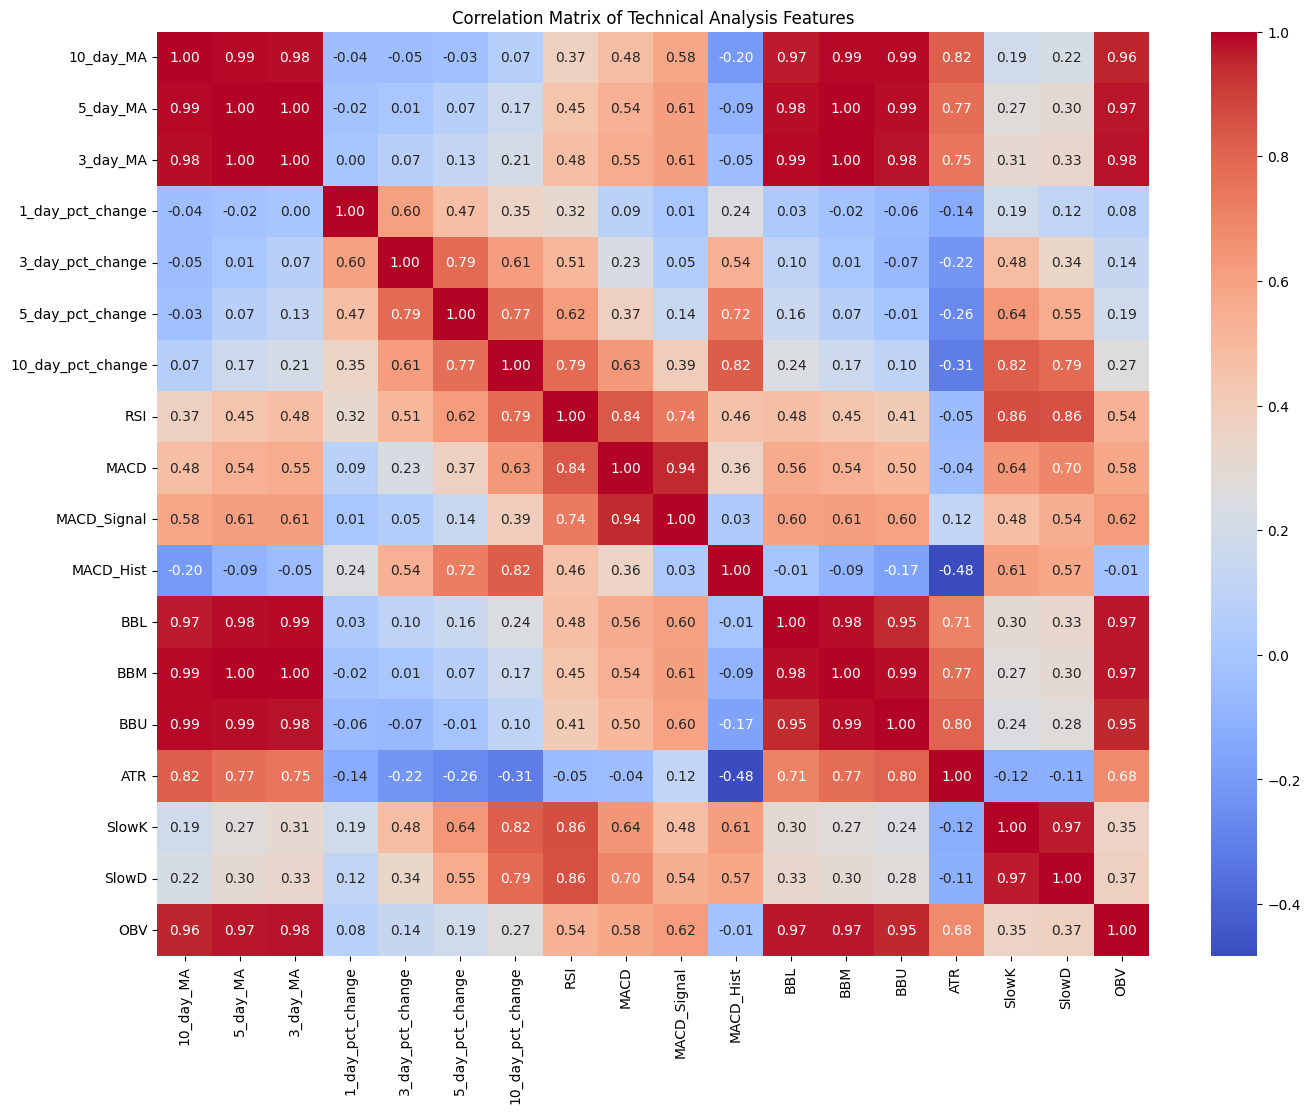

In [54]:
technical_features = [
    '10_day_MA', '5_day_MA', '3_day_MA',
    '1_day_pct_change', '3_day_pct_change', '5_day_pct_change', '10_day_pct_change',
    'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist',
    'BBL', 'BBM', 'BBU',
    'ATR', 'SlowK', 'SlowD',
    'OBV'
]



correlation_matrix = aapl_df[technical_features].iloc[:250].corr()


plt.figure(figsize=(16, 12))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Technical Analysis Features')
plt.show()

# Training

In [66]:
# ---- 1. Data Preprocessing ----
scaler = MinMaxScaler()
aapl_df_scaled = aapl_df.copy()  # Avoid modifying the original DataFrame
aapl_df_scaled[technical_features] = scaler.fit_transform(aapl_df_scaled[technical_features])


# ---- 2. Sequence Creation ----
def create_sequences(df, seq_length=50):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df.iloc[i:i+seq_length][technical_features].to_numpy())  # Convert explicitly
        y.append(df.iloc[i+seq_length]['Price Movement'])  # Ensure this is 1D
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(aapl_df_scaled)



# ---- 3. Train-Test Split ----


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---- 4. Build LSTM Model ----
lstm_model = Sequential([
    Input(shape=(seq_length, len(technical_features))),  # Explicit Input Layer
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(32, activation="relu"),  # Dense layer before RF
    Dense(18, activation="relu"),  # Reduce dimensionality for RF
])

# ---- 5. Feature Extraction from LSTM ----

# Access the input layer directly:
input_layer = lstm_model.layers[0].input # Get the input layer
output_layer = lstm_model.layers[-1].output # Get the output layer


# Define the feature extractor model:
feature_extractor = Model(inputs=input_layer, outputs=output_layer)

# Build and compile the model:
lstm_model.compile(optimizer='adam', loss='mse') # Build implicitly


# Predictions
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [67]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the extracted LSTM features
rf_classifier.fit(X_train_features, y_train)

RandomForestClassifier(random_state=42)

In [68]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}
 # Step 2: Your classifier
grid_search = RandomizedSearchCV(rf_classifier, param_grid, n_iter = 20, cv=5,scoring="accuracy", random_state=42) #n_iter=20 for RandomizedSearch
grid_search.fit(X_train_features, y_train)
print(grid_search.best_params_)

best_estimator = grid_search.best_estimator_

{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'bootstrap': False}


In [69]:
# Make predictions on the testing data
y_pred = best_estimator.predict(X_test_features)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Get a more detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.4812150279776179
              precision    recall  f1-score   support

           0       0.46      0.58      0.51       584
           1       0.52      0.39      0.45       667

    accuracy                           0.48      1251
   macro avg       0.49      0.49      0.48      1251
weighted avg       0.49      0.48      0.48      1251

